In [1]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
import time
from sklearn import metrics
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import numpy as np
from warnings import filterwarnings
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from src.data.fics_dataset import  FICSDatasetBuilder

filterwarnings("ignore")



In [2]:
PROJECT_PATH=os.getenv('PROJECT_PATH')
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))
FICS_MIN_YEAR=int(os.getenv('FICS_MIN_YEAR'))
FICS_MAX_YEAR=int(os.getenv('FICS_MAX_YEAR'))
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))
BUILD_FICS_GAME_TYPE=(os.getenv('BUILD_FICS_GAME_TYPE'))


In [3]:
def get_samples(players_dict,offset,num_samples):
    samples={}
    for p in players_dict:
        try:
            v=players_dict[p]
            arr=list(v[(v.index<offset+num_samples)&(v.index>=offset)]["Elo"])
            samples[p]=arr
        except Exception as err:
            print(err)
            pass
        
    for p in list(samples.keys()):
        if len(samples[p])!=num_samples:
            del samples[p]

    
    return samples

def get_samples_ts(players_dict,offset,num_samples):
    samples={}
    for p in players_dict:
        try:
            v=players_dict[p]
            arr_Timestamp=(v[(v.index<offset+num_samples)&(v.index>=offset)]["Timestamp"])
            samples[p]=arr_Timestamp
        except Exception as err:
            print(err)
            pass
        
    for p in list(samples.keys()):
        if len(samples[p])!=num_samples:
            del samples[p]

    print(samples)
    return samples

def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)


def kmeans_silhoutte(X_train,metric,max_k=10):
    silhoutte_score = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        y_pred = model.fit_predict(X_train)
        score = silhouette_score(X_train, y_pred, metric=metric)
        silhoutte_score.append(score)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(range(2,10),silhoutte_score,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('silhoutte');
    plt.title("Silhouette analysis For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-Silhouette-plot-{metric}-{max_k}.png")

    return silhoutte_score

def kmeans_calinski_harabasz(X_train,metric,max_k=10):
    scores = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        y_pred = model.fit_predict(X_train)
        score = metrics.calinski_harabasz_score(X_train, y_pred)
        scores.append(score)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(range(2,10),scores,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('calinski harabasz');
    plt.title("calinski harabasz For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-calinski-harabasz-plot-{metric}-{max_k}.png")

    return scores



def kmeans_wcsss(X_train,metric,model_name,max_k=10):
    wcss = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        model.fit_predict(X_train)
        print(model.inertia_)
        wcss.append(model.inertia_)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,max_k+1))
    plt.grid()
    plt.plot(range(2,max_k+1),wcss,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('WCSSS');
    plt.title("WCSSS analysis For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-wcsss-plot-{model_name}.png")

    return wcss

def kmeans_cluster(n_clusters,algo,X_train,metric):
    model= TimeSeriesKMeans(n_clusters=n_clusters,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)
    y_pred = model.fit_predict(X_train)
    # model.to_pickle(f"{PROJECT_PATH}/models/fics/{algo}.pkl")



    for yi in range(len(np.unique(y_pred))):
      for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)


      plt.plot(model.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, X_train.shape[1])
      plt.ylim(-5, 5)
      plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
      plt.title("kmeans")
      plt.tight_layout()
      plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/{algo}-clusters-{(yi + 1)}-{n_clusters}-{metric}.png")
      plt.show();
  

    for i in range(len(np.unique(y_pred))):
      count = (sum(y_pred == i)/len(y_pred))*100
      print(f"The {count:.2f}% of the observations fall into Cluster {i + 1}")

    return y_pred



In [7]:
df

,Unnamed: 0,Player,Elo,Date,Time,FICSGamesDBGameNo,Year,Month,Day
0,0,Strikko,1606,2019.11.30,08:05:00,455505130,2019,11,30
1,1,Wychbold,1311,2019.11.30,08:07:00,455505129,2019,11,30
2,2,Shaderman,1567,2019.11.30,08:06:00,455505128,2019,11,30
3,3,aussenschnapp,1680,2019.11.30,08:05:00,455505126,2019,11,30
4,4,pfink,1288,2019.11.30,07:56:00,455505123,2019,11,30
...,...,...,...,...,...,...,...,...,...
27489758,14529246,bretteux,1155,2018.08.09,12:16:00,434845469,2018,8,9
27489759,14529247,HWPer,1520,2018.08.09,12:12:00,434845468,2018,8,9
27489760,14529248,Jonfern,1676,2018.08.09,12:13:00,434845467,2018,8,9
27489761,14529249,Jesuslovesall,1423,2018.08.09,12:14:00,434845465,2018,8,9


In [8]:
df=df[df["Year"]==2018]

In [9]:
df

,Unnamed: 0,Player,Elo,Date,Time,FICSGamesDBGameNo,Year,Month,Day
9472,9687,rizaisfa,1540,2018.08.31,07:58:00,455492835,2018,8,31
10225,10469,pietroa,828,2018.08.19,13:51:00,450877124,2018,8,19
16296,16795,Calx,1621,2018.11.25,16:53:00,450869119,2018,11,25
18553,19134,DixierRebel,1504,2018.11.20,07:52:00,450866229,2018,11,20
18569,19151,DixierRebel,1542,2018.11.10,15:59:00,450866210,2018,11,10
...,...,...,...,...,...,...,...,...,...
27489758,14529246,bretteux,1155,2018.08.09,12:16:00,434845469,2018,8,9
27489759,14529247,HWPer,1520,2018.08.09,12:12:00,434845468,2018,8,9
27489760,14529248,Jonfern,1676,2018.08.09,12:13:00,434845467,2018,8,9
27489761,14529249,Jesuslovesall,1423,2018.08.09,12:14:00,434845465,2018,8,9


In [14]:
from datetime import datetime, timedelta
import pandas as pd

def create_weekly_intervals(dates, values):
    # Convert the input dates to datetime objects
    date_values = [(datetime.strptime(date, '%Y.%m.%d %H:%M:%S'), value) for date, value in zip(dates, values)]
    
    # Sort the date-value pairs by date
    date_values.sort(key=lambda x: x[0])
    
    weekly_intervals = []
    current_week_start = None
    current_interval = []

    for date, value in date_values:
        if current_week_start is None:
            current_week_start = date

        current_interval.append((date, value))

        # Check if we've reached the end of the current week
        if date.weekday() == 6:  # Sunday
            weekly_intervals.append((current_week_start.strftime('%Y-%U'), current_interval))
            current_week_start = None
            current_interval = []

    # If there are any remaining dates, add them to the last interval
    if current_interval:
        weekly_intervals.append((current_week_start.strftime('%Y-%U'), current_interval))

    return weekly_intervals

def get_interval(dates,values,interval):
    
    # Convert to DataFrame
    df = pd.DataFrame({'Date': pd.to_datetime(dates), 'Value': values})
    
    # Group by year
    grouped = df.groupby(df['Date'].dt.year)
    
    result={
        "Elo":[],
        "Date":[],
    }
    
    # Iterate over each group
    for year, group in grouped:
        
        # Iterate over each interval of 90 days
        start_date = pd.to_datetime([f'{year}-01-01 00:00:00']).min()
        while start_date.year == year:
            end_date = start_date + pd.Timedelta(days=interval)
            interval_data = group[(group['Date'] >= start_date) & (group['Date'] <= end_date)]
            result["Elo"].append(list(interval_data["Value"]))
            result["Date"].append(list(interval_data["Date"]))
                
            start_date = end_date + pd.Timedelta(days=1)
    return pd.DataFrame.from_dict(result)
def get_v(r):
    if len(r)>0:
        return r[-1]
    return None

def get_samples_interval(df,interval):
    groups={g:data for g,data in df.groupby("Player")}

    frames={}
    for g in (groups.keys()):
        curr=groups[g]
        curr["Timestamp"]=(curr["Date"]+" "+curr["Time"])
        curr=get_interval(curr["Timestamp"],curr["Elo"],interval)
        curr["Elo"]=curr["Elo"].apply(lambda r:get_v(r))
        curr["Date"]=curr["Date"].apply(lambda r:get_v(r))
        last=len(curr.index)-1
        frames[g]=curr[curr.index!=last]
    
    g=list(frames.keys())[0]
    frames[g]
    
    
    samples={"Player":list(frames.keys())}
    for i in frames[g].index:
        samples[i]=[]
    
    for g in frames.keys():
        for i in frames[g].index:
            curr=frames[g]
            samples[i].append(list(curr[curr.index==i]["Elo"])[0])
            
    samples_df=pd.DataFrame.from_dict(samples)
    samples_df=samples_df.dropna()
    samples_df.index=list(samples_df["Player"])
    samples_df=samples_df.drop(columns="Player")
    return samples_df

In [12]:
PATH=f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered-reorgainzed-3_v2.csv"
df=pd.read_csv(PATH)
df=df[df["Year"]==2018]


In [15]:
df=get_samples_interval(df,90)

In [16]:
df

,0,1,2,3
ABSBEGINNER,1317.0,1356.0,1289.0,1288.0
ADJUSTOR,1893.0,1862.0,1917.0,1939.0
AFCERGY,1532.0,1637.0,1600.0,1546.0
AFRF,1353.0,1387.0,1285.0,1344.0
AGMC,1455.0,1415.0,1417.0,1483.0
...,...,...,...,...
zurichess,2263.0,2291.0,2385.0,2318.0
zwartspeler,1821.0,1818.0,1818.0,1700.0
zxtxf,1331.0,1362.0,1309.0,1398.0
zyrq,1496.0,1464.0,1402.0,1380.0


In [20]:
from scipy.stats import skew
from tsfresh.feature_extraction.feature_calculators import mean_abs_change
from scipy.stats import shapiro


def get_df(df):
    df_dt=df.copy()

    for i in range(1,len(df_dt.columns)):
        df_dt[i]=df[i]-df[i-1]

    df_dt[0]=df[0]-df[0]
    return df_dt

def find_features(df,features):
    df_dt=get_df(df)

    feature_values=[[] for i in range(len(features))]


    for p in df.index:
        c=list(df[df.index==p].values)[0]
        for i in range(len(features)):
            feature_values[i].append(features[i]["func"](c))

    for i in range(len(features)):
        
        if (shapiro(feature_values[i]).pvalue)< 0.1:
            print(shapiro(feature_values[i]).pvalue)
            df_dt[features[i]["name"]]=feature_values[i]

    return df_dt





2024-04-04 21:27:22,930 - numba.cuda.cudadrv.driver - INFO - init
2024-04-04 21:27:22,942 - numba.cuda.cudadrv.driver - ERROR - Call to cuInit results in CUDA_ERROR_UNKNOWN


In [ ]:
PATH

In [21]:
from  tsfresh.feature_extraction.feature_calculators import kurtosis
all_features=[
    {"name":"mean","func":lambda c:np.mean(c)},
    {"name":"skew","func":lambda c:skew(c)},
    {"name":"min","func":lambda c:min(c)},
    {"name":"max","func":lambda c:max(c)},
    {"name":"var","func":lambda c:np.var(c)},
    {"name":"kurtosis","func":lambda c:kurtosis(c)},
    ]


find_features(df,all_features)


8.708066742666314e-34
0.0
1.7550873570206472e-30
2.0435002444941917e-32
0.0
0.0


,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,mean,skew,min,max,var,kurtosis
osvifr,0,6,-9,7,2,7,-9,-10,5,6,...,-4,6,7,5,1589.920,0.571836,1527,1660,690.763600,0.053917
Anmelus,0,-29,-12,-11,68,50,-48,39,-26,-43,...,11,-2,-2,-6,1521.450,0.332503,1452,1630,916.257500,0.146178
Tohotmos,0,-39,-7,-1,6,9,-10,-8,10,7,...,-5,10,5,6,1527.960,-0.090739,1458,1589,898.878400,-0.700760
denij,0,-19,-23,12,5,5,13,6,6,5,...,-7,-1,13,21,1499.905,0.003392,1434,1579,846.655975,-0.354141
diegoandrescas,0,-5,9,9,9,-9,-3,-5,6,6,...,-6,0,-2,-13,1393.960,0.428641,1328,1462,655.328400,-0.076310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PaulVerhoeven,0,-10,7,6,6,5,7,7,-1,7,...,11,-5,-7,9,1748.445,0.503749,1664,1854,1827.206975,-0.304969
davefromreading,0,36,-65,41,-32,23,-31,20,13,13,...,-6,-10,4,-7,1388.015,-0.456155,1288,1457,1807.774775,-0.799471
schlechterZug,0,47,-140,42,-78,63,41,49,-8,23,...,8,-10,7,-9,1947.245,-1.000507,1738,2020,2138.214975,2.069510
replo,0,47,35,-34,23,-4,-4,27,26,28,...,16,-12,14,15,1240.250,-0.742968,1046,1369,1973.667500,3.264480


In [ ]:
list(df.index)

In [23]:
from sklearn.cluster import DBSCAN

In [22]:
!pip install -U aeon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 15.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 16.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4


In [36]:
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
osvifr,1597,1603,1594,1601,1603,1610,1601,1591,1596,1602,...,1645,1651,1655,1660,1651,1638,1634,1640,1647,1652
Anmelus,1510,1481,1469,1458,1526,1576,1528,1567,1541,1498,...,1548,1540,1547,1541,1536,1531,1542,1540,1538,1532
Tohotmos,1582,1543,1536,1535,1541,1550,1540,1532,1542,1549,...,1511,1519,1525,1521,1517,1524,1519,1529,1534,1540
denij,1501,1482,1459,1471,1476,1481,1494,1500,1506,1511,...,1496,1509,1496,1500,1492,1504,1497,1496,1509,1530
diegoandrescas,1440,1435,1444,1453,1462,1453,1450,1445,1451,1457,...,1368,1366,1364,1360,1353,1349,1343,1343,1341,1328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PaulVerhoeven,1757,1747,1754,1760,1766,1771,1778,1785,1784,1791,...,1686,1678,1679,1673,1664,1672,1683,1678,1671,1680
davefromreading,1332,1368,1303,1344,1312,1335,1304,1324,1337,1350,...,1431,1438,1429,1435,1438,1441,1435,1425,1429,1422
schlechterZug,1867,1914,1774,1816,1738,1801,1842,1891,1883,1906,...,1997,1989,1991,1998,2005,2012,2020,2010,2017,2008
replo,1046,1093,1128,1094,1117,1113,1109,1136,1162,1190,...,1223,1210,1203,1190,1202,1212,1228,1216,1230,1245


In [37]:

%%time

# Standardizing (z-score normalization) a dataset involves rescaling the distribution of values
ss = StandardScaler()

scaled_ss = ss.fit_transform(df.T)
df_ss = pd.DataFrame(scaled_ss.T, columns=df.columns, index=df.index)
X_ss = df_ss.values
display(df_ss.head())

# Normalization
mm = MinMaxScaler()
scaled_mm = mm.fit_transform(df.T)
df_mm = pd.DataFrame(scaled_mm.T, columns=df.columns, index=df.index)
X_mm = df_mm.values
display(df_mm.head())


# convert dataframe to time_series_dataset
X = to_time_series_dataset(df.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
osvifr,0.269382,0.497672,0.155237,0.421575,0.497672,0.764010,0.421575,0.041092,0.231334,0.459623,...,2.095700,2.323990,2.476183,2.666425,2.323990,1.829362,1.677169,1.905459,2.171797,2.362039
Anmelus,-0.378265,-1.336318,-1.732753,-2.096152,0.150315,1.802129,0.216388,1.504803,0.645859,-0.774701,...,0.877113,0.612823,0.844077,0.645859,0.480678,0.315497,0.678896,0.612823,0.546751,0.348533
Tohotmos,1.802457,0.501646,0.268167,0.234813,0.434938,0.735125,0.401584,0.134751,0.468292,0.701771,...,-0.565686,-0.298853,-0.098728,-0.232145,-0.365561,-0.132082,-0.298853,0.034688,0.201459,0.401584
denij,0.037632,-0.615348,-1.405798,-0.993389,-0.821552,-0.649715,-0.202939,0.003265,0.209469,0.381306,...,-0.134205,0.312571,-0.134205,0.003265,-0.271674,0.140734,-0.099837,-0.134205,0.312571,1.034287
diegoandrescas,1.798481,1.603164,1.954735,2.306306,2.657877,2.306306,2.189115,1.993798,2.228179,2.462559,...,-1.014087,-1.092214,-1.170341,-1.326594,-1.600039,-1.756292,-1.990673,-1.990673,-2.068800,-2.576625


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
osvifr,0.526316,0.571429,0.503759,0.556391,0.571429,0.624060,0.556391,0.481203,0.518797,0.563910,...,0.887218,0.932331,0.962406,1.000000,0.932331,0.834586,0.804511,0.849624,0.902256,0.939850
Anmelus,0.325843,0.162921,0.095506,0.033708,0.415730,0.696629,0.426966,0.646067,0.500000,0.258427,...,0.539326,0.494382,0.533708,0.500000,0.471910,0.443820,0.505618,0.494382,0.483146,0.449438
Tohotmos,0.946565,0.648855,0.595420,0.587786,0.633588,0.702290,0.625954,0.564885,0.641221,0.694656,...,0.404580,0.465649,0.511450,0.480916,0.450382,0.503817,0.465649,0.541985,0.580153,0.625954
denij,0.462069,0.331034,0.172414,0.255172,0.289655,0.324138,0.413793,0.455172,0.496552,0.531034,...,0.427586,0.517241,0.427586,0.455172,0.400000,0.482759,0.434483,0.427586,0.517241,0.662069
diegoandrescas,0.835821,0.798507,0.865672,0.932836,1.000000,0.932836,0.910448,0.873134,0.917910,0.962687,...,0.298507,0.283582,0.268657,0.238806,0.186567,0.156716,0.111940,0.111940,0.097015,0.000000


(7275, 200, 1) (7275, 200, 1)
CPU times: user 743 ms, sys: 51.8 ms, total: 795 ms
Wall time: 798 ms


In [38]:
k_means = TimeSeriesKMeans(
    n_clusters=2,  # Number of desired centers
    init_algorithm="random",  # initialisation technique: random, first or kmeans++
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="dtw",  # Distance metric to use
    averaging_method="mean",  # Averaging technique to use
    random_state=1,  # Makes deterministic
)

k_means.fit(X_train)
plot_cluster_algorithm(k_means, X_train, k_means.n_clusters)

In [31]:
X_train

array([[[ 573.,  375.,  301.,  212.,   55.,   34.,   25.,   33.,  113.,
          143.,  303.,  615., 1226., 1281., 1221., 1081.,  866., 1096.,
         1039.,  975.,  746.,  581.,  409.,  182.]],

       [[ 394.,  264.,  140.,  144.,  104.,   28.,   28.,   25.,   70.,
          153.,  401.,  649., 1216., 1399., 1249., 1240., 1109., 1137.,
         1290., 1137.,  791.,  638.,  597.,  316.]],

       [[ 603.,  348.,  176.,  177.,   47.,   30.,   40.,   42.,  101.,
          180.,  401.,  777., 1344., 1573., 1408., 1243., 1141., 1178.,
         1256., 1114.,  814.,  635.,  304.,  168.]],

       [[ 428.,  309.,  199.,  117.,   82.,   43.,   24.,   64.,  152.,
          183.,  408.,  797., 1288., 1491., 1523., 1460., 1365., 1520.,
         1700., 1797., 1596., 1139.,  910.,  640.]],

       [[ 372.,  310.,  203.,  133.,   65.,   39.,   27.,   36.,  107.,
          139.,  329.,  651.,  990., 1027., 1041.,  971., 1104.,  844.,
         1023., 1019.,  862.,  643.,  591.,  452.]],

       [[ 

In [27]:
temp = TimeSeriesKMeans(
    init_algorithm="kmeans++",  # initialisation technique: random, or kmeans++
)
print(temp.init_algorithm)

kmeans++


In [28]:
TimeSeriesKMeans(
    distance="dtw",  # DTW distance with 25% warping allowed
    distance_params={"window": 0.25},
)

TimeSeriesKMeans(distance='dtw', distance_params={'window': 0.25})

In [29]:
temp = TimeSeriesKMeans(distance="euclidean", averaging_method="mean")
print(temp.get_params())
TimeSeriesKMeans(
    distance="msm", averaging_method="ba", average_params={"max_iters": 10}
)

{'average_params': None, 'averaging_method': 'mean', 'distance': 'euclidean', 'distance_params': None, 'init_algorithm': 'random', 'max_iter': 300, 'n_clusters': 8, 'n_init': 10, 'random_state': None, 'tol': 1e-06, 'verbose': False}


TimeSeriesKMeans(average_params={'max_iters': 10})

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

<Figure size 500x1000 with 0 Axes>

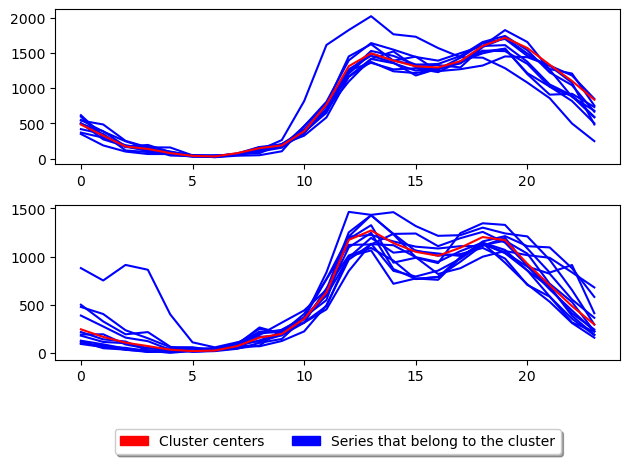

In [30]:
k_means = TimeSeriesKMeans(
    n_clusters=2,  # Number of desired centers
    init_algorithm="random",  # initialisation technique: random, first or kmeans++
    max_iter=10,  # Maximum number of iterations for refinement on training set
    distance="dtw",  # Distance metric to use
    averaging_method="mean",  # Averaging technique to use
    random_state=1,  # Makes deterministic
)

k_means.fit(X_train)
plot_cluster_algorithm(k_means, X_test, k_means.n_clusters)

 Returned results in shape (111, 8)


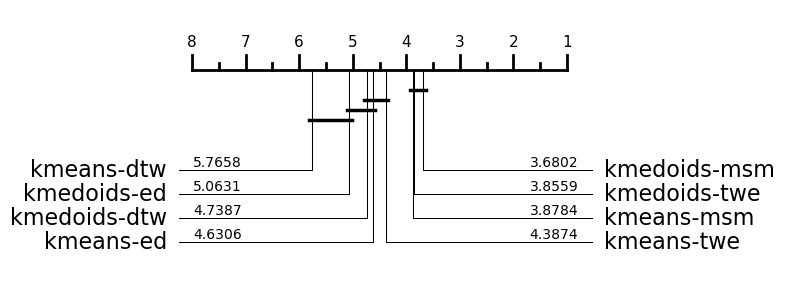

In [32]:
from aeon.benchmarking.results_loaders import get_estimator_results_as_array
from aeon.visualisation import plot_critical_difference

# 1. MSM is the most effective distance function
clusterers = [
    "kmeans-ed",
    "kmeans-dtw",
    "kmeans-msm",
    "kmeans-twe",
    "kmedoids-ed",
    "kmedoids-dtw",
    "kmedoids-msm",
    "kmedoids-twe",
]
accuracy, data_names = get_estimator_results_as_array(
    task="clustering", estimators=clusterers, measure="clacc"
)
print(f" Returned results in shape {accuracy.shape}")
plt = plot_critical_difference(accuracy, clusterers)